## Datank Challenge

### Indice
    1) Limpieza de base de datos y EDA
    2) EDA
    3) GEDA
    4) Otros análisis
    5) Análisis espacial
    6) Predicción de propina

Notas:
- El presente trabajo no se enfoca en resolver una pregunta específica, sino que abarca diferentes temas y análisis que consideré relevantes.
- Para la ejecución de este notebook se utilizó un servidor de CMU de 88 cores IX y 754 GB de RAM

In [1]:
import numpy as np
import pandas as pd
from ggplot import *
import matplotlib  
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

/zfsauton/home/kdgutier/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/zfsauton/home/kdgutier/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1) Limpieza de base de datos y EDA

En esta primera parte realizo la limpieza de los datos, que incluye: identificar missing values, eliminar outliers y crear variables adicionales.

In [2]:
data = pd.read_csv('../data/yellow_tripdata_2016-01.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


A continuación se reporta la cantidad de missing values en cada columna. Como se puede observar no hay missing values en la base.

In [3]:
data.isnull().sum(axis=0)

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

A continuación se crean variables adicionales que serán útiles para análisis posteriores y se modifica el formato de las variables de hora.

In [4]:
# Dia del viaje
data_clean = data
data_clean["pickup_day"] = pd.to_numeric(data_clean["tpep_pickup_datetime"].str.slice(8, 10))
# Hora del viaje
data_clean["pickup_hour"] = pd.to_numeric(data_clean["tpep_pickup_datetime"].str.slice(11, 13))
# Hora de inicio de viaje en formato datetime
data_clean["tpep_pickup_datetime"] = pd.to_datetime(data_clean["tpep_pickup_datetime"])
# Hora de fin de viaje en formato datetime
data_clean["tpep_dropoff_datetime"] = pd.to_datetime(data_clean["tpep_dropoff_datetime"])
#  Tiempo de viaje en horas
data_clean["trip_time"] = (data_clean.tpep_dropoff_datetime-data_clean.tpep_pickup_datetime).astype('timedelta64[s]')/3600
# Velocidad promedio en millas por hora
data_clean['average_speed'] = data_clean['trip_distance']/data_clean['trip_time']
# Costo promedio por milla
data_clean['cost_per_mile'] = data_clean['fare_amount']/data_clean['trip_distance']
# Porcentaje de propina del costo del viaje
data_clean['tip_percentage'] = 100*data_clean['tip_amount'] / data_clean['fare_amount']
# Día de la semana
data_clean.loc[data_clean['pickup_day'] % 7 == 1, 'week_day'] = 'Fri'
data_clean.loc[data_clean['pickup_day'] % 7 == 2, 'week_day'] = 'Sat'
data_clean.loc[data_clean['pickup_day'] % 7 == 3, 'week_day'] = 'Sun'
data_clean.loc[data_clean['pickup_day'] % 7 == 4, 'week_day'] = 'Mon'
data_clean.loc[data_clean['pickup_day'] % 7 == 5, 'week_day'] = 'Tue'
data_clean.loc[data_clean['pickup_day'] % 7 == 6, 'week_day'] = 'Wed'
data_clean.loc[data_clean['pickup_day'] % 7 == 0, 'week_day'] = 'Thu'

A continuación se decodifican variables categoricas relevantes

In [5]:
replacements = {
   'payment_type': {
      1: 'Credit Card',
      2: 'Cash',
      3: 'No charge',
      4: 'Dispute',
      5: 'Unknown'},
    'VendorID': {
      1: 'Creative Mobile Technologies',
      2: 'VeriFone Inc.'},
    'RatecodeID': {
      1: 'Standard rate',
      2: 'JFK',
      3: 'Newark',
      4: 'Nassau or Westchester',
      5: 'Negotiated fare',
      6: 'Group ride',
      99: 'NA'}
}

data_clean.replace(replacements, inplace=True)

Para identificar outliers se reportan diversos percentiles, valores máximos y mínimos de las variables numéricas

In [6]:
data_clean.describe(percentiles=[.01, .25, .5, .75, .99, .999])

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_hour,trip_time,average_speed,cost_per_mile,tip_percentage
count,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.089580e+07,1.090574e+07,1.090392e+07
mean,1.670847e+00,4.648197e+00,-7.281869e+01,4.011494e+01,-7.288659e+01,4.015315e+01,1.248693e+01,3.130757e-01,4.976705e-01,1.750663e+00,2.933453e-01,2.997245e-01,1.564140e+01,1.598853e+01,1.354638e+01,2.544802e-01,inf,NaN,inf
std,1.324891e+00,2.981095e+03,9.168964e+00,5.051022e+00,8.900841e+00,4.903456e+00,3.556400e+01,4.156792e-01,5.046685e-02,2.623546e+00,1.694572e+00,1.232553e-02,3.641280e+01,8.883062e+00,6.391860e+00,1.448452e+00,NaN,NaN,NaN
min,0.000000e+00,0.000000e+00,-1.219343e+02,0.000000e+00,-1.219335e+02,0.000000e+00,-9.576000e+02,-4.261000e+01,-5.000000e-01,-2.208000e+02,-1.740000e+01,-3.000000e-01,-9.584000e+02,1.000000e+00,0.000000e+00,-7.325000e-01,-1.470000e+03,-inf,-1.000000e+02
1%,1.000000e+00,2.000000e-01,-7.401404e+01,0.000000e+00,-7.401490e+01,0.000000e+00,3.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,4.300000e+00,1.000000e+00,0.000000e+00,2.055556e-02,2.535211e+00,2.748414e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399151e+01,4.073630e+01,-7.399107e+01,4.073481e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00,9.000000e+00,9.000000e+00,1.055556e-01,7.918782e+00,4.193548e+00,0.000000e+00
50%,1.000000e+00,1.670000e+00,-7.398138e+01,4.075369e+01,-7.397942e+01,4.075413e+01,9.000000e+00,0.000000e+00,5.000000e-01,1.260000e+00,0.000000e+00,3.000000e-01,1.162000e+01,1.600000e+01,1.400000e+01,1.744444e-01,1.061662e+01,5.333333e+00,1.818182e+01
75%,2.000000e+00,3.080000e+00,-7.396610e+01,4.076808e+01,-7.396196e+01,4.076962e+01,1.400000e+01,5.000000e-01,5.000000e-01,2.320000e+00,0.000000e+00,3.000000e-01,1.716000e+01,2.300000e+01,1.900000e+01,2.813889e-01,1.442017e+01,6.756757e+00,2.290909e+01
99%,6.000000e+00,1.865000e+01,0.000000e+00,4.080513e+01,0.000000e+00,4.083480e+01,5.200000e+01,1.000000e+00,5.000000e-01,1.167000e+01,5.540000e+00,3.000000e-01,6.999000e+01,3.100000e+01,2.300000e+01,8.983333e-01,3.581152e+01,2.000000e+01,3.830769e+01
99.9%,6.000000e+00,2.490000e+01,0.000000e+00,4.084188e+01,0.000000e+00,4.088798e+01,8.250000e+01,1.000000e+00,5.000000e-01,1.880000e+01,1.265000e+01,3.000000e-01,1.065500e+02,3.100000e+01,2.300000e+01,2.373417e+01,5.331420e+01,inf,1.000000e+02


Se consideró "outlier" a los casos superiores al percentil 99.9% o valores que no tuvieran sentido (como costo o tiempo de viaje 0). Esto ya que se encontró que en casi todas las variables relevantes para los futuros analisis existen valores que probablemente sean errores (por ejemplo costos de viaje de 100,000usd). Es importante mencionar que sólo se identifican los outliers, no se eliminan las observaciones. El objetivo principal de esta limpieza es para obtener gráficas interpretables en el GEDA. Dependiendo del análisis se optará por considerar o no los outliers.

In [29]:
data_clean['outlier'] = 0
data_clean.loc[(data['trip_distance'] <= 0) | (data_clean['trip_distance'] > 2.490000e+01), 'outlier'] = 1
data_clean.loc[(data_clean['trip_time'] <= 0) | (data_clean['trip_time'] > 8.983333e-01), 'outlier'] = 1
data_clean.loc[(data_clean['total_amount'] <= 0) | (data_clean['total_amount'] > 1.065500e+02), 'outlier'] = 1
data_clean.loc[(data_clean['fare_amount'] <= 0) | (data_clean['fare_amount'] > 8.250000e+01), 'outlier'] = 1
data_clean.loc[(data_clean['tip_amount'] < 0) | (data_clean['tip_amount'] > 1.880000e+01), 'outlier'] = 1
data_clean.loc[(data_clean['average_speed'] <= 0) | (data_clean['average_speed'] > 5.331420e+01), 'outlier'] = 1
data_clean.loc[(data_clean['cost_per_mile'] <= 0) | (data_clean['cost_per_mile'] > 2.000000e+01), 'outlier'] = 1
data_clean['outlier'].sum()

246398

Con el criterio anterior se identificaron 246,398 outliers (2% del total de observaciones)

A continuación se muestran estadísticos para las variables numéricas.

In [30]:
data_clean.loc[data_clean['outlier']==0].describe(percentiles=[.01, .25, .5, .75, .99])

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_hour,trip_time,average_speed,cost_per_mile,tip_percentage,outlier
count,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,1.066046e+07,10660460.0
mean,1.672364e+00,2.781715e+00,-7.290726e+01,4.016369e+01,-7.302815e+01,4.023121e+01,1.199299e+01,3.159342e-01,4.991548e-01,1.678701e+00,2.516468e-01,2.999960e-01,1.503843e+01,1.595746e+01,1.355848e+01,2.128249e-01,1.210067e+01,5.733032e+00,1.421057e+01,0.0
std,1.326427e+00,3.257549e+00,8.819649e+00,4.858673e+00,8.310685e+00,4.578443e+00,9.195130e+00,3.657739e-01,2.353194e-02,2.100587e+00,1.237526e+00,1.094900e-03,1.136836e+01,8.882486e+00,6.401479e+00,1.473730e-01,6.263046e+00,2.200838e+00,7.408165e+01,0.0
min,0.000000e+00,1.000000e-02,-1.008229e+02,0.000000e+00,-1.008229e+02,0.000000e+00,1.000000e-02,-3.269000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e-01,1.000000e+00,0.000000e+00,8.333333e-04,2.386602e-01,4.032258e-04,0.000000e+00,0.0
1%,1.000000e+00,3.000000e-01,-7.401395e+01,0.000000e+00,-7.401458e+01,0.000000e+00,3.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,4.800000e+00,1.000000e+00,0.000000e+00,3.027778e-02,3.515152e+00,2.791667e+00,0.000000e+00,0.0
25%,1.000000e+00,1.000000e+00,-7.399155e+01,4.073680e+01,-7.399109e+01,4.073531e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00,8.000000e+00,9.000000e+00,1.066667e-01,7.978022e+00,4.210526e+00,0.000000e+00,0.0
50%,1.000000e+00,1.680000e+00,-7.398151e+01,4.075396e+01,-7.397949e+01,4.075434e+01,9.000000e+00,0.000000e+00,5.000000e-01,1.260000e+00,0.000000e+00,3.000000e-01,1.144000e+01,1.600000e+01,1.400000e+01,1.741667e-01,1.063087e+01,5.329949e+00,1.818182e+01,0.0
75%,2.000000e+00,3.000000e+00,-7.396658e+01,4.076819e+01,-7.396230e+01,4.076977e+01,1.400000e+01,5.000000e-01,5.000000e-01,2.260000e+00,0.000000e+00,3.000000e-01,1.680000e+01,2.300000e+01,1.900000e+01,2.777778e-01,1.437700e+01,6.666667e+00,2.290909e+01,0.0
99%,6.000000e+00,1.790000e+01,0.000000e+00,4.080493e+01,0.000000e+00,4.083311e+01,5.200000e+01,1.000000e+00,5.000000e-01,1.056000e+01,5.540000e+00,3.000000e-01,6.530000e+01,3.100000e+01,2.300000e+01,7.300000e-01,3.495463e+01,1.339286e+01,3.780000e+01,0.0
max,9.000000e+00,2.490000e+01,0.000000e+00,6.090876e+01,0.000000e+00,6.090876e+01,8.250000e+01,8.500000e+00,3.349000e+01,1.880000e+01,9.782000e+01,3.000000e-01,1.065500e+02,3.100000e+01,2.300000e+01,8.980556e-01,5.331298e+01,2.000000e+01,1.850000e+05,0.0


Como puntos relevantes de la tabla anterior destaco:
- En promedio los viajes son de 2.87 millas
- En promedio la tarifa de los viajes es 12.3usd, y la tarifa promedio por milla es 6.42usd.
- Entre el 25% y 50% de los pasajeros no dejan propina. Esto puede estar sesgado ya que no se considera la propina en efectivo. La propina promedio es 1.72usd y el porcentaje de propina promedio es 14.2%
- El costo total promedio asciende a 15.4usd
- Los viajes duran en promedio 0.23 horas y tienen una velocidad promedio de 12.1 millas/hora.

A continuación se muestra la matriz de correlaciones de las variables numéricas (no se incluyen todas).

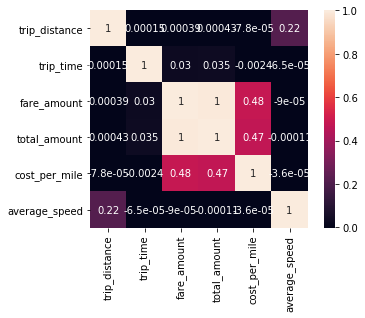

In [31]:
corrmat = data_clean[['trip_distance','trip_time','fare_amount', 'total_amount','cost_per_mile', 'average_speed']].corr()
sns.heatmap(corrmat, annot=True, square = True)
plt.show()

### 2) GEDA

#### GEDA univariado

A continuacion se muestra un análisis gráfico de las variables.

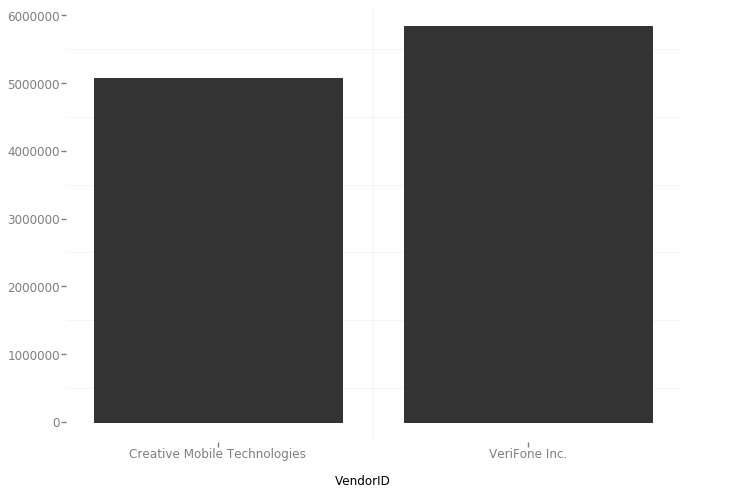

<ggplot: (-9223363284591043952)>

In [10]:
ggplot(aes(x='VendorID'), data=data_clean) + geom_bar() + theme_bw()

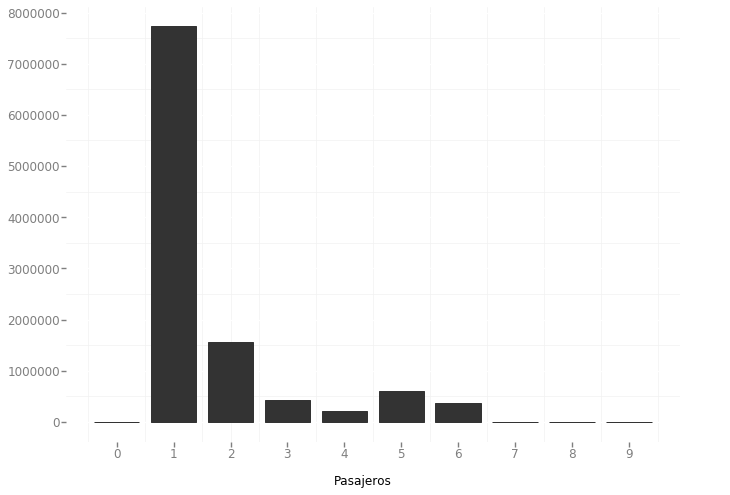

<ggplot: (8752230223087)>

In [11]:
ggplot(aes(x='passenger_count'), data=data_clean) + geom_bar() + theme_bw() + xlab("Pasajeros")

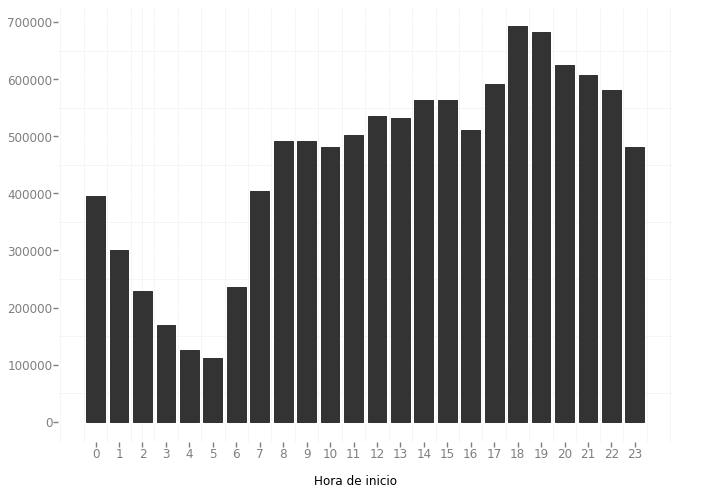

<ggplot: (8752263738653)>

In [12]:
ggplot(aes(x='pickup_hour'), data=data_clean) + geom_bar() + theme_bw() + xlab("Hora de inicio")

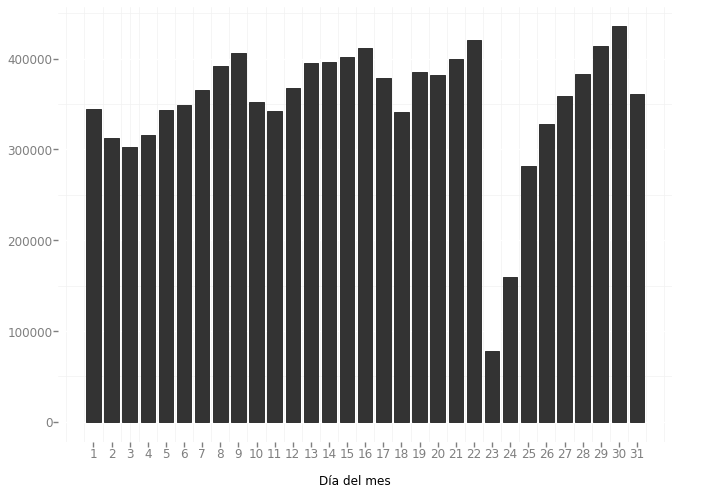

<ggplot: (-9223363284591043854)>

In [15]:
ggplot(aes(x='pickup_day'), data=data_clean) + geom_bar() + theme_bw() + xlab("Día del mes")

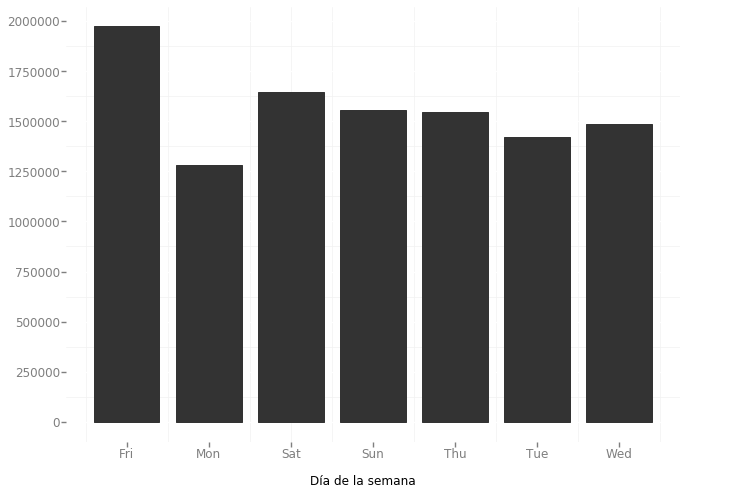

<ggplot: (8752230199279)>

In [13]:
ggplot(aes(x='week_day'), data=data_clean) + geom_bar() + theme_bw() + xlab("Día de la semana")

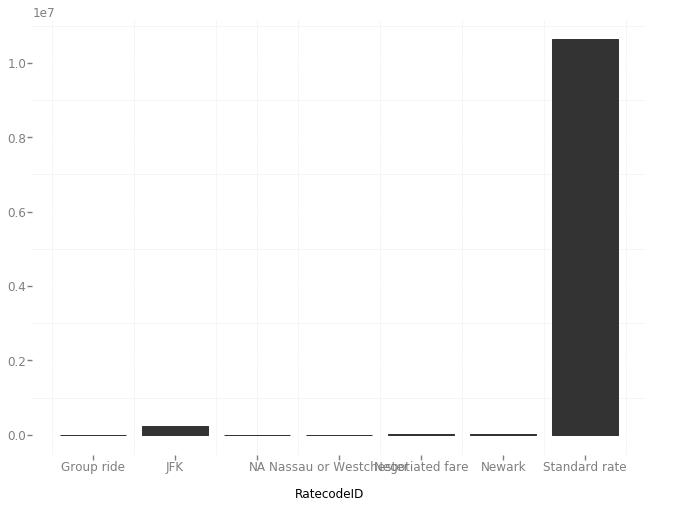

<ggplot: (8752230110742)>

In [16]:
ggplot(aes(x='RatecodeID'), data=data_clean) + geom_bar() + theme_bw()

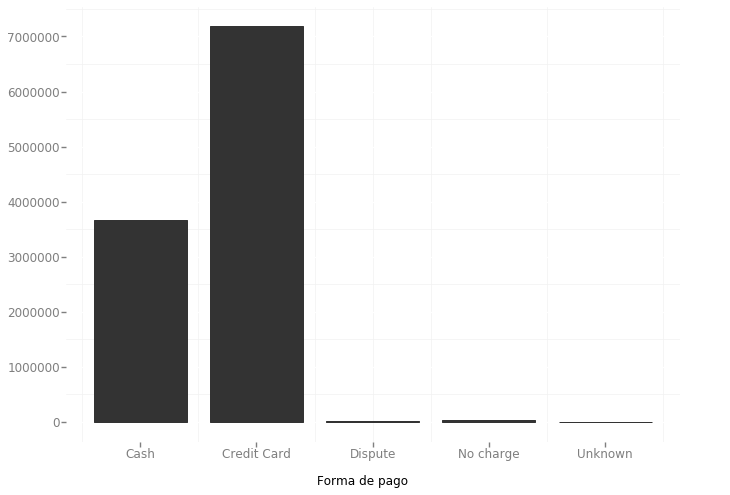

<ggplot: (-9223363284624894471)>

In [17]:
ggplot(aes(x='payment_type'), data=data_clean) + geom_bar() + theme_bw() + xlab("Forma de pago")

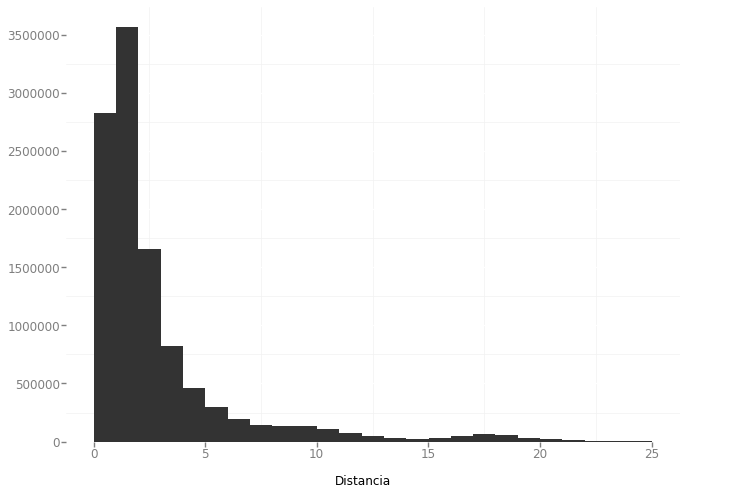

<ggplot: (-9223363284624915880)>

In [18]:
ggplot(aes(x='trip_distance'), data=data_clean.loc[data_clean['outlier']==0]) + geom_histogram(binwidth=1) + theme_bw() + xlab("Distancia")

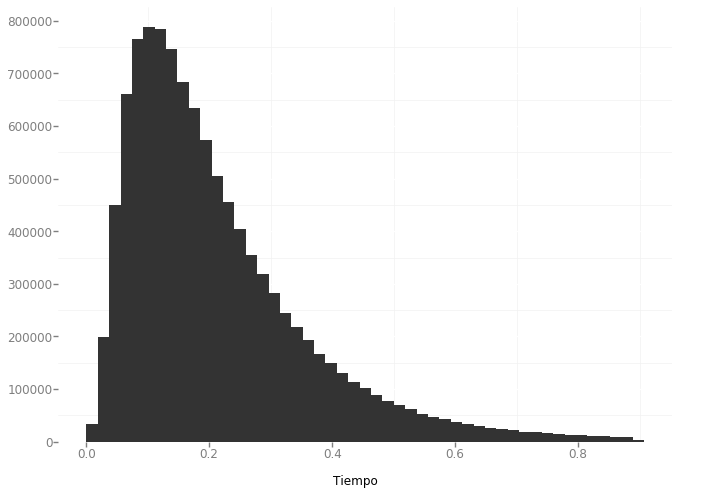

<ggplot: (-9223363284625013160)>

In [23]:
ggplot(aes(x='trip_time'), data=data_clean.loc[data_clean['outlier']==0]) + geom_histogram(binwidth=1.0/(0.9*60.0)) + theme_bw() + xlab("Tiempo")

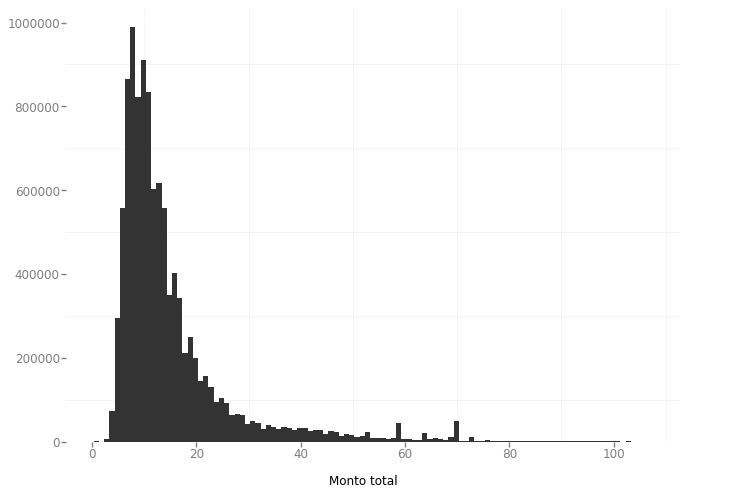

<ggplot: (-9223363284624848766)>

In [24]:
ggplot(aes(x='total_amount'), data=data_clean.loc[data_clean['outlier']==0]) + geom_histogram(binwidth=1) + theme_bw() + xlab("Monto total")

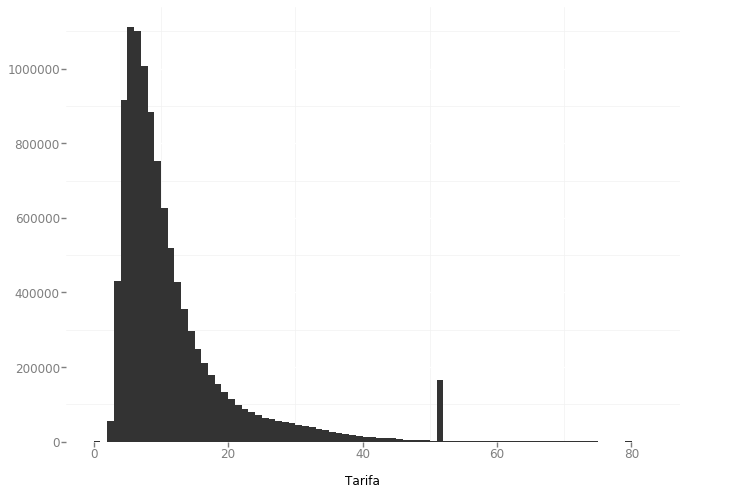

<ggplot: (-9223363284640137626)>

In [25]:
ggplot(aes(x='fare_amount'), data=data_clean.loc[data_clean['outlier']==0]) + geom_histogram(binwidth=1) + theme_bw() + xlab("Tarifa")

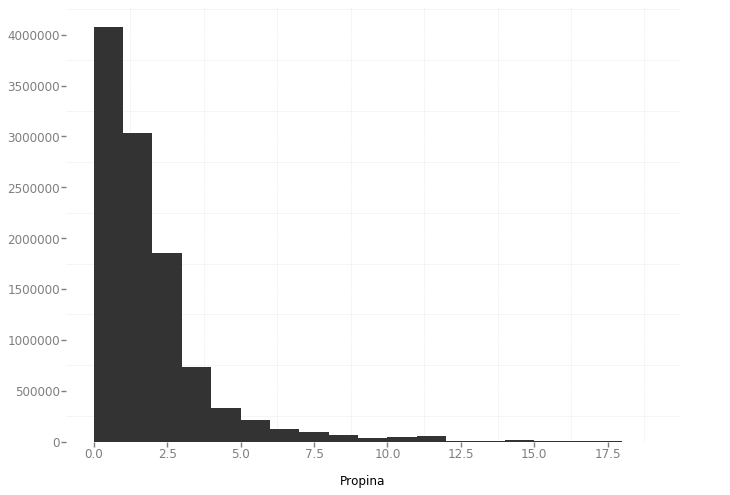

<ggplot: (8752214278569)>

In [27]:
ggplot(aes(x='tip_amount'), data=data_clean.loc[data_clean['outlier']==0]) + geom_histogram(binwidth=1) + theme_bw() + xlab("Propina")

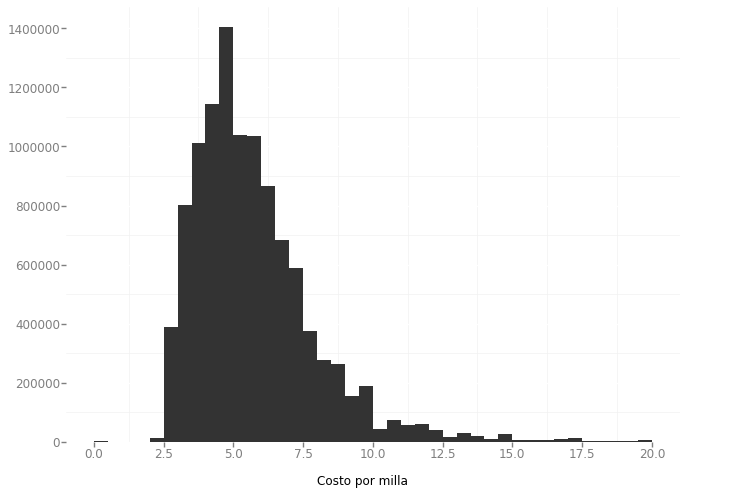

<ggplot: (8752214383771)>

In [32]:
ggplot(aes(x='cost_per_mile'), data=data_clean.loc[data_clean['outlier']==0]) + geom_histogram(binwidth=0.5) + theme_bw() + xlab("Costo por milla")

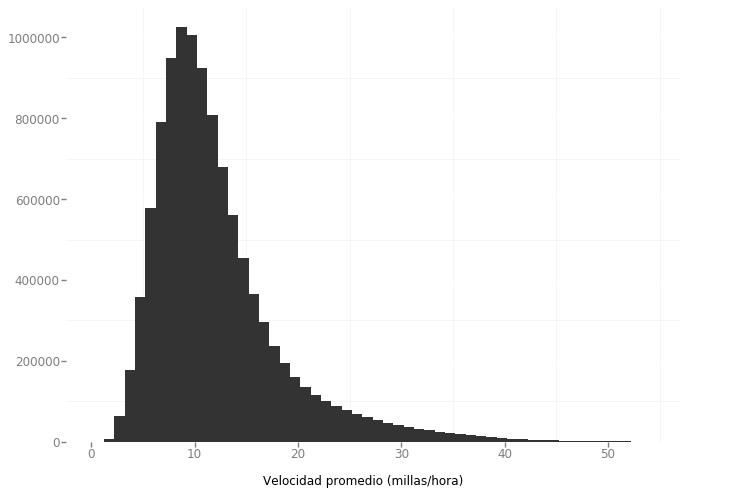

<ggplot: (8752213513676)>

In [33]:
ggplot(aes(x='average_speed'), data=data_clean.loc[data_clean['outlier']==0]) + geom_histogram(binwidth=1) + theme_bw() + xlab("Velocidad promedio (millas/hora)")

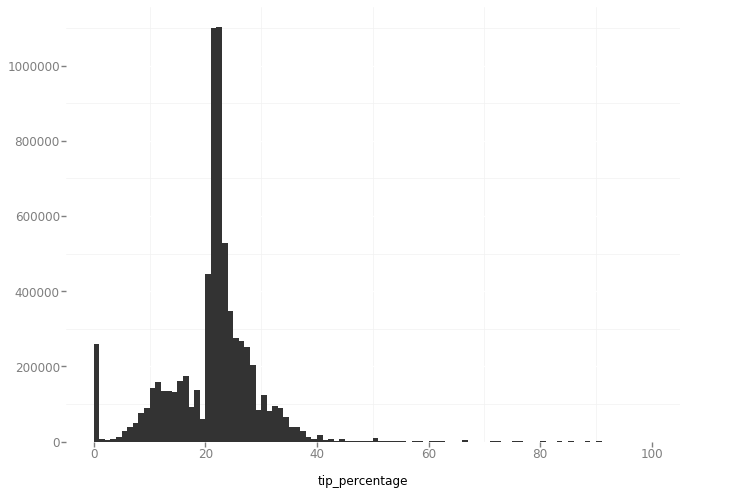

<ggplot: (8752208554132)>

In [35]:
ggplot(aes(x='tip_percentage'), data=data_clean.loc[(data_clean['tip_percentage'] >= 0) & (data_clean['tip_percentage'] < 100) & (data_clean['payment_type'] == 'Credit Card')]) + geom_histogram(binwidth=1) + theme_bw()

### GEDA Bivariado

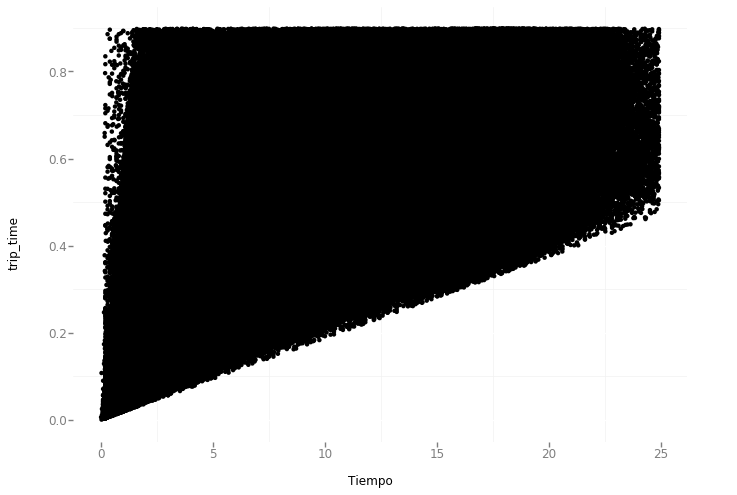

<ggplot: (8752183114360)>

In [37]:
ggplot(aes(x ='trip_distance', y = 'trip_time'), data = data_clean.loc[data_clean['outlier']==0]) + geom_point() + theme_bw() + xlab("Distancia") + ylab("Tiempo")

De la gráfica anterior se puede observar que, como era de esperar, existe una relación positiva entre distancia y tiempo.

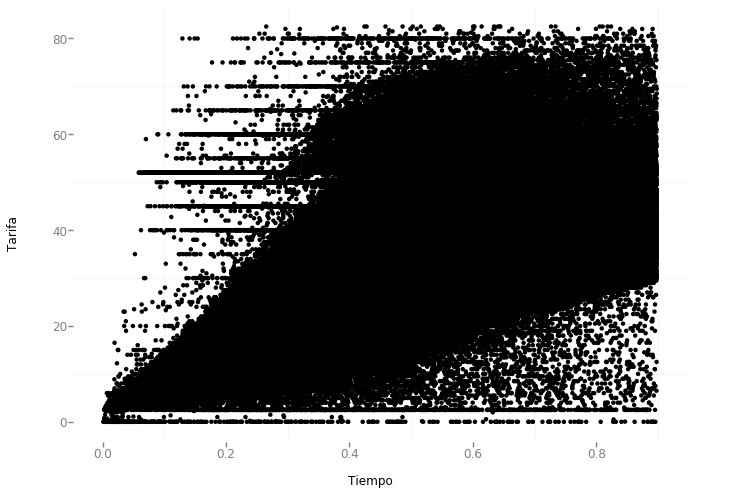

<ggplot: (8752152459440)>

In [39]:
ggplot(aes(x ='trip_time', y = 'fare_amount'), data = data_clean.loc[data_clean['outlier']==0]) + geom_point() + theme_bw() + xlab("Tiempo") + ylab("Tarifa")

De la gráfica anterior se puede observar que, existe una relación positiva entre tiempo y costo de la tarifa

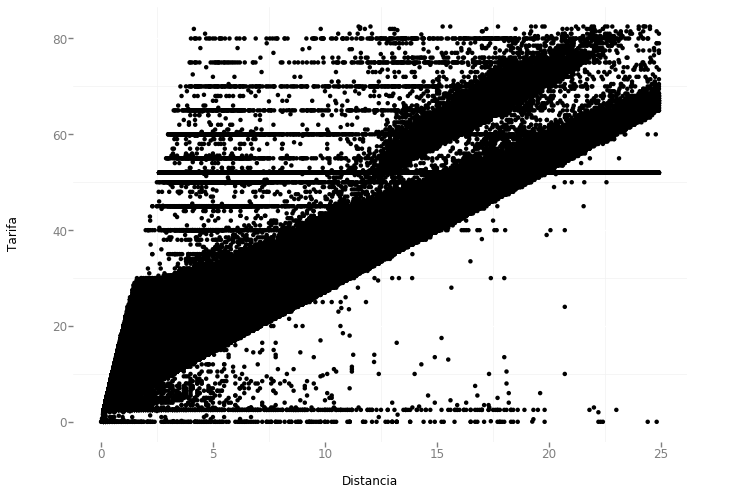

<ggplot: (8752152644672)>

In [40]:
ggplot(aes(x ='trip_distance', y = 'fare_amount'), data =data_clean.loc[data_clean['outlier']==0]) + geom_point() + theme_bw() + xlab("Distancia") + ylab("Tarifa")

De la gráfica anterior se puede observar que, existe una relación positiva entre distancia y costo de la tarifa

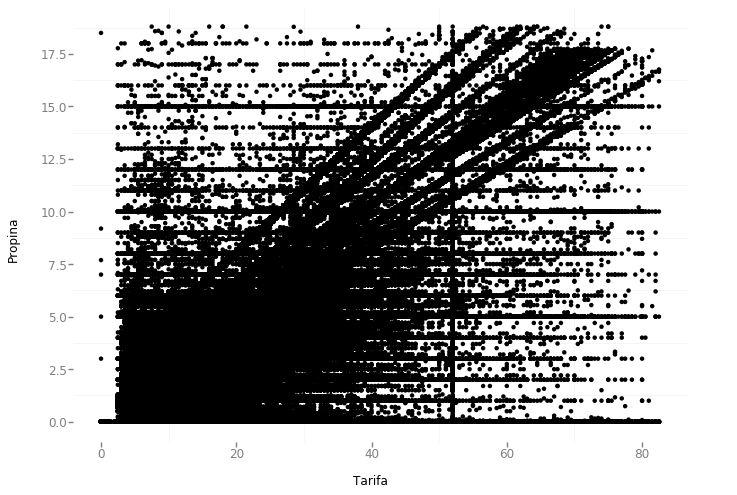

<ggplot: (8752152431424)>

In [41]:
ggplot(aes(x ='fare_amount', y = 'tip_amount'), data =data_clean.loc[data_clean['outlier']==0]) + geom_point() + theme_bw() + xlab("Tarifa") + ylab("Propina")

De la grafica anterior se pueden observar varios hechos intersantes. Las lineas rectas con pendiente positiva indica que hay viajes en los que se que dan propinas proporcionales a la tarifa (20%,30%,etc.). Por otro lado las lineas horizonates indican que en otros viajes se dan propinas "fijas", como por ejemplo 5usd, 10usd, etc.

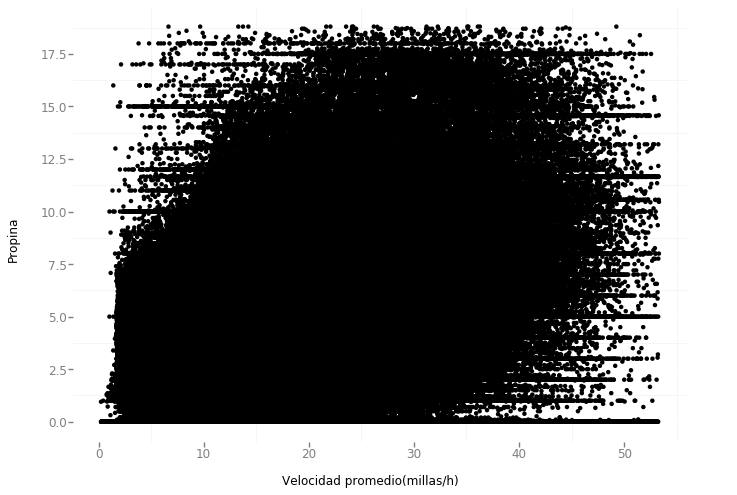

<ggplot: (-9223363287787266914)>

In [42]:
ggplot(aes(x ='average_speed', y = 'tip_amount'), data =data_clean.loc[data_clean['outlier']==0]) + geom_point() + theme_bw() + xlab("Velocidad promedio(millas/h)") + ylab("Propina")

La gráfica anterior parece sugerir que existe una correlación positiva entre velocidad promedio y propina, aunque no muy fuerte. Esto puede deberse a que, como se verá más adelánte, hay una correlación positiva entre distancia y velocidad promedio (y a mayor distancia más tarifa,y por ende propina).

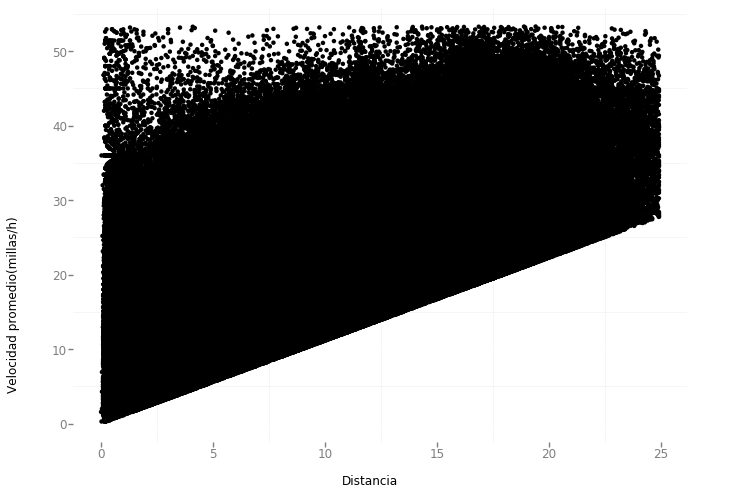

<ggplot: (-9223363287787260072)>

In [43]:
ggplot(aes(x ='trip_distance', y = 'average_speed'), data =data_clean.loc[data_clean['outlier']==0]) + geom_point() + theme_bw() + xlab("Distancia") + ylab("Velocidad promedio(millas/h)")

La gráfica anterior muestra que existe una relación positiva entre distancia y velocidad promedio

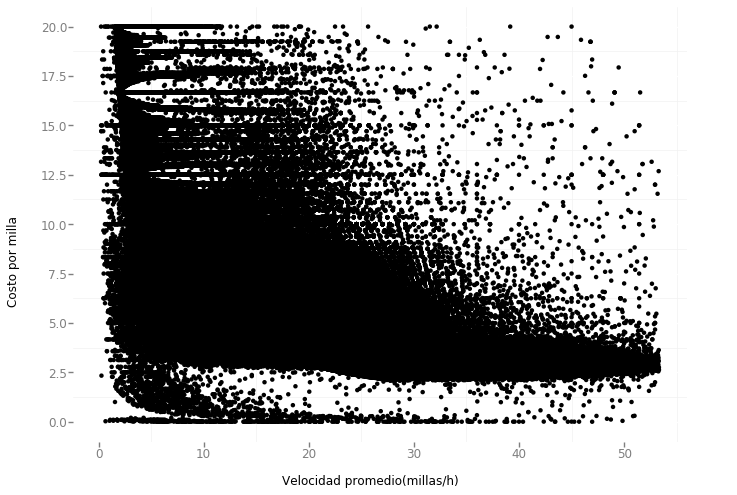

<ggplot: (8752151357988)>

In [44]:
ggplot(aes(x ='average_speed', y = 'cost_per_mile'), data =data_clean.loc[data_clean['outlier']==0]) + geom_point() + theme_bw() + xlab("Velocidad promedio(millas/h)") + ylab("Costo por milla")

La gráfica anterior muestra que existe una relación negativa entre velocidad promedio y costo por milla.

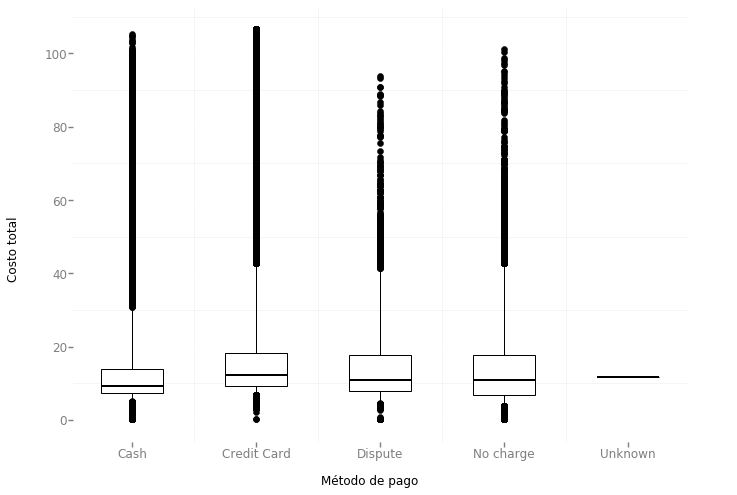

<ggplot: (-9223363287787259406)>

In [45]:
ggplot(aes(x ='payment_type', y = 'total_amount'), data =data_clean.loc[data_clean['outlier']==0]) + geom_boxplot() + theme_bw() + xlab("Método de pago") + ylab("Costo total")

De la gráfica anterior se puede destacar que, en promedio, se utilizan tarjetas de crédito para montos más altos

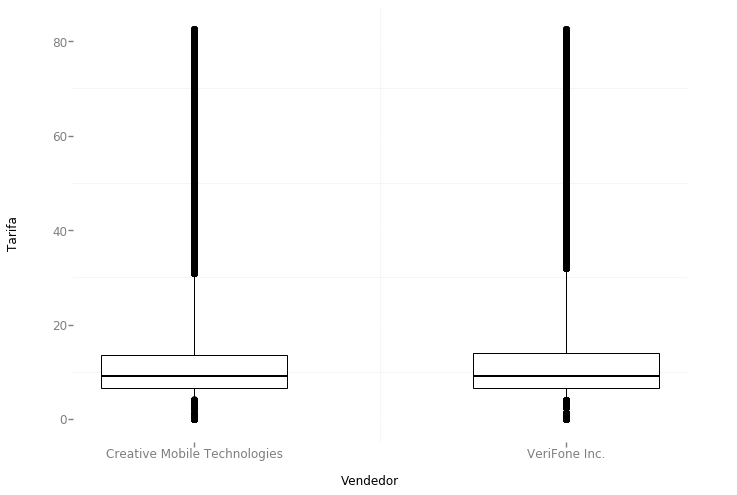

<ggplot: (8749067507674)>

In [46]:
ggplot(aes(x ='VendorID', y = 'fare_amount'), data =data_clean.loc[data_clean['outlier']==0]) + geom_boxplot() + theme_bw() + xlab("Vendedor") + ylab("Tarifa")

No se aprecian diferencias en la distribución de la tarifa entre ambos Vendors

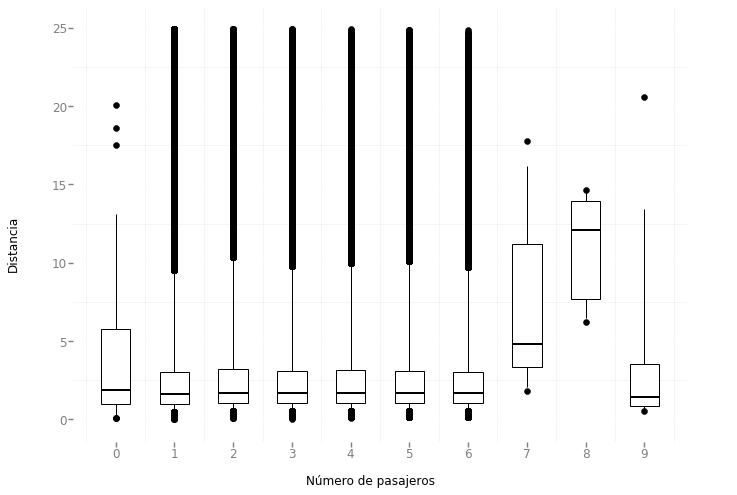

<ggplot: (8749275711012)>

In [47]:
ggplot(aes(x ='passenger_count', y = 'trip_distance'), data =data_clean.loc[data_clean['outlier']==0]) + geom_boxplot() + theme_bw() + xlab("Número de pasajeros") + ylab("Distancia")

Se puede observar que la distribución de distancia es prácticamente igual para viajes con hasta 6 pasajeros y 9 pasajeros. En viajes de 7 y 8 pasajeros la distancia aumenta considerablemente. Se decidió incluir los viajes con 0 pasajeros para detectar diferencias con el resto de los viajes.

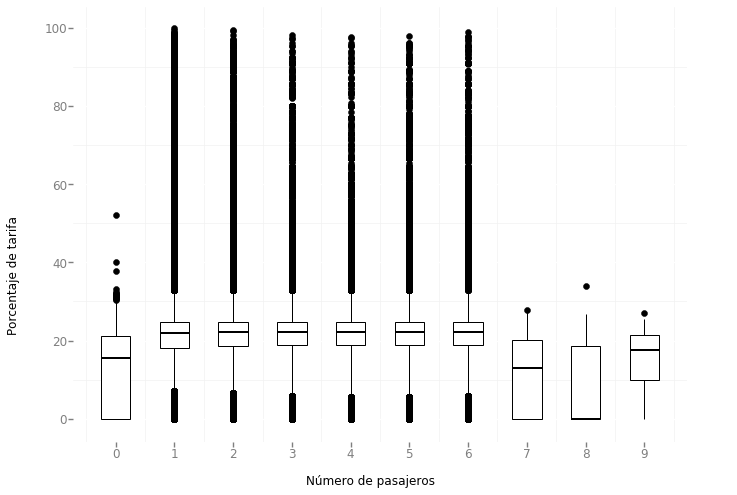

<ggplot: (8752152378944)>

In [48]:
ggplot(aes(x ='passenger_count', y = 'tip_percentage'), data =data_clean.loc[(data_clean['tip_percentage'] >= 0) & (data_clean['tip_percentage'] < 100) & (data_clean['payment_type'] == 'Credit Card')]) + geom_boxplot() + theme_bw() + xlab("Número de pasajeros") + ylab("Porcentaje de tarifa")

Al igual que en el caso anterior, existe una diferencia importante entre viajes con 7 y 8 pasajeros y el resto.

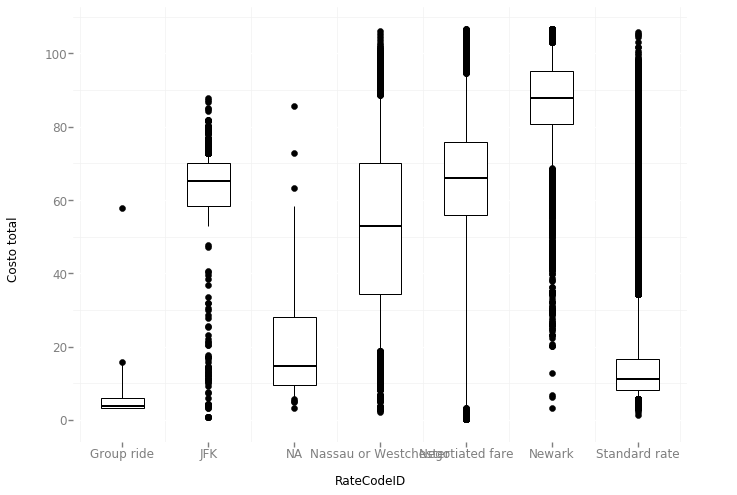

<ggplot: (-9223363287787250814)>

In [49]:
ggplot(aes(x ='RatecodeID', y = 'total_amount'), data =data_clean.loc[data_clean['outlier']==0]) + geom_boxplot() + theme_bw() + xlab("RateCodeID") + ylab("Costo total")

De la gráfica anterior se puede observar que existe una diferencia importante en el costo total del viaje entre los diferentes "rate codes". Los viajes con tárifa estándar son generalmente de costos más bajos. Los viajes más caros corresponden a los viajes hacia Newark.

### 3) Otros análisis

La riqueza de la información de la base permite una gran variedad de análisis de diferentes temas. En particular me resultó interesante utilizar los datos para analizar patrones en el tráfico. Es importante mencionar que resultados podrían estar sesgados por el hecho de que sólo se tienen viajes de taxis.

Se analizó además patrones en el costo promedio por milla de los viajes en taxis.

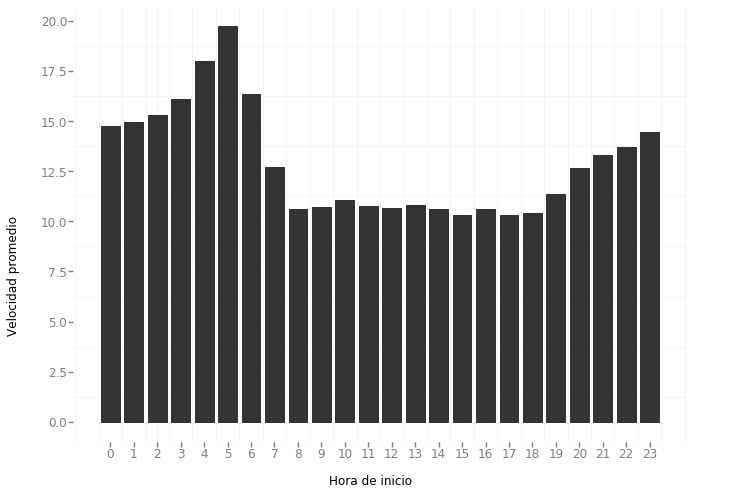

<ggplot: (-9223363284722215708)>

In [51]:
means = data_clean.loc[data_clean['outlier']==0][['pickup_hour','average_speed']].groupby(['pickup_hour']).mean().reset_index()
ggplot(aes(x ='pickup_hour', weight = 'average_speed'), data = means) + geom_bar() + theme_bw() + xlab("Hora de inicio") + ylab("Velocidad promedio")

En la gráfica anterior se puede ver la velocidad promedio de los viajes en diferentes horarios. Se observa que entre las 8am y 6pm se tiene la menor velocidad promedio. Es interesante que entre estos horarios no se observan grandes diferencias. Como era de esperar la velocidad promedio es mayor durante la noche y madrugada.

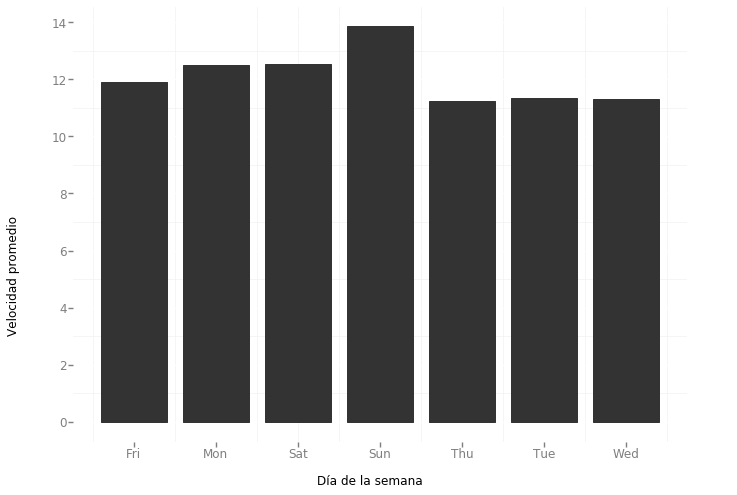

<ggplot: (8752183372352)>

In [52]:
means = data_clean.loc[data_clean['outlier']==0][['average_speed','week_day']].groupby(['week_day']).mean().reset_index()
ggplot(aes(x ='week_day', weight = 'average_speed'), data = means) + geom_bar() + theme_bw() + xlab("Día de la semana") + ylab("Velocidad promedio")

La gráfica anterior muestra la velocidad promedio para diferentes días de la semana. Como era de esperar la velocidad promedio es mayor durante el fin de semana. Resulta interesante sin embargo que la velocidad es muy similar entre el lunes y el sábado. Los días con mayor tráfico corresponden a los martes, miercoles y jueves.

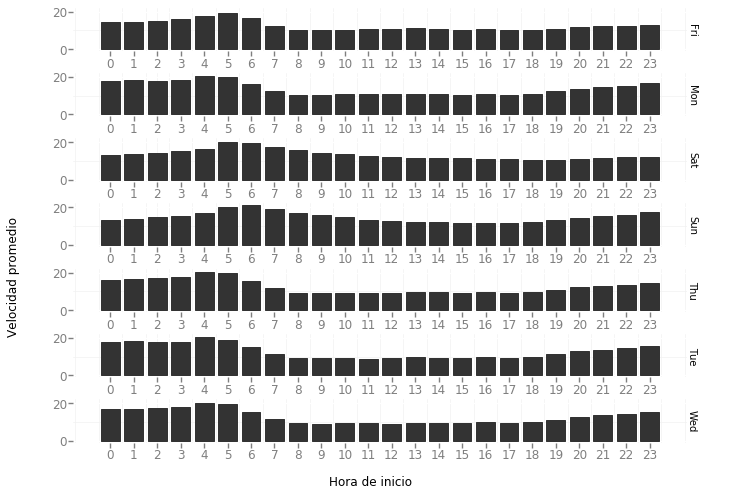

<ggplot: (8752133059483)>

In [55]:
means = data_clean.loc[data_clean['outlier']==0][['pickup_hour','week_day','average_speed']].groupby(['pickup_hour','week_day']).mean().reset_index()
ggplot(aes(x ='pickup_hour', weight = 'average_speed'), data = means) + geom_bar() + theme_bw() + facet_grid('week_day') + xlab("Hora de inicio") + ylab("Velocidad promedio")

La gŕafica anterior muestra la velocidad promedio por hora y día de la semana. Se observa un patrón similar para todos los días.

La velocidad promedio está correlacionada con un mayor costo por milla, ya que la tarifa depende de la distancia y el tiempo. A continuación se muestra el costo promedio por milla por hora y dia de la semana.

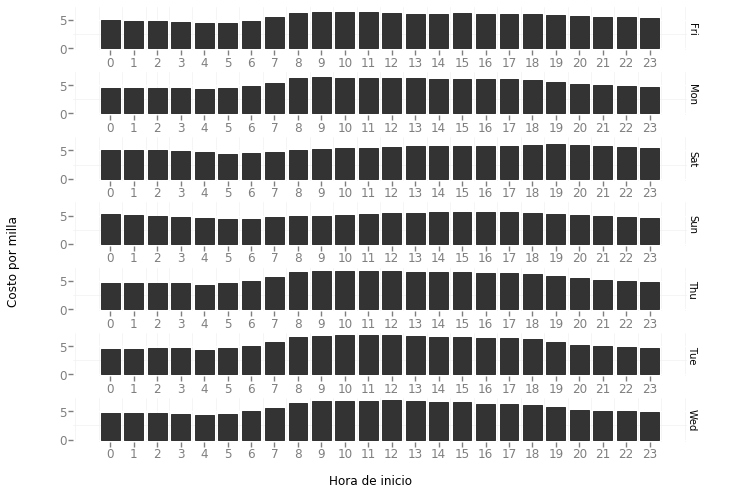

<ggplot: (-9223363284722650161)>

In [56]:
means = data_clean.loc[data_clean['outlier']==0][['pickup_hour','week_day','cost_per_mile']].groupby(['pickup_hour','week_day']).mean().reset_index()
ggplot(aes(x ='pickup_hour', weight = 'cost_per_mile'), data = means) + geom_bar() + theme_bw() + facet_grid('week_day')+ xlab("Hora de inicio") + ylab("Costo por milla")

Los resultados anteriores son útiles para encontrar los horarios con mayor tráfico en la ciudad y en los que, como consecuencia, resulta más caro utilizar taxis (por milla). En el análisis siguiente se identificaran zonas con mayor tráfico.

### Espacial

/zfsauton/home/kdgutier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  del sys.path[0]


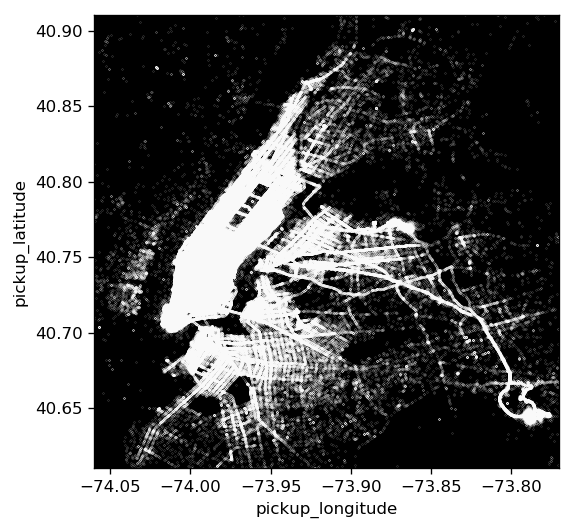

In [61]:
import matplotlib  
import matplotlib.pyplot as plt

%matplotlib inline 

new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
rcParams['figure.figsize'] = (5, 5)
rcParams['figure.dpi'] = 120

P=data_clean.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',color='white', xlim=(-74.05,-73.75),ylim=(40.6, 40.9),s=.02,alpha=.6)
P.set_axis_bgcolor('black')

In [ ]:
%matplotlib inline 

new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
rcParams['figure.figsize'] = (5, 5)
rcParams['figure.dpi'] = 120

P=data_clean.loc[data_clean['outlier']==0].plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',c='trip_distance', cmap='autumn', xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
P.set_axis_bgcolor('black')

/zfsauton/home/kdgutier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if __name__ == '__main__':


In [ ]:
%matplotlib inline 

new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
rcParams['figure.figsize'] = (5, 5)
rcParams['figure.dpi'] = 120

P=data_clean.loc[(data_clean['average_speed'] > 0) & (data_clean['average_speed'] <= 30.0)].plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',c='average_speed', cmap='autumn', xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
P.set_axis_bgcolor('black')

In [ ]:
%matplotlib inline 

pd.options.display.mpl_style = 'default'
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
rcParams['figure.figsize'] = (5, 5)
rcParams['figure.dpi'] = 120

P=data_clean.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',c='cost_per_mile', cmap='autumn', xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
P.set_axis_bgcolor('black')

### Prediccion de tips

In [ ]:
# Paquetes para pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Paquetes para curva ROC y precision_recall
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

# Paquete para AUC
from sklearn.metrics import roc_auc_score

In [ ]:
data_tips = data_clean.loc[data_clean['payment_type'] == 'Credit Card']

data_tips['high_tip'] =(data_tips['tip_percentage'] > 22.08).astype(int)

columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'VendorID', 'payment_type', 'store_and_fwd_flag', 'fare_amount', 'tip_amount', 'tip_percentage', 'total_amount', 'cost_per_mile', 'mta_tax', 'improvement_surcharge', 'pick_format', 'dropoff_format', 'Unnamed: 0','dropoff_longitude','dropoff_latitude', 'trip_time','tolls_amount','pickup_day']
data_tips.drop(columns, inplace=True, axis=1)
data_tips.head()

In [ ]:
data_tips = data_tips.round({'pickup_longitude': 2, 'pickup_latitude': 2})

data_tips['pickup_hour'] = data_tips['pickup_hour'].astype('category')
data_tips['pickup_latitude'] = data_tips['pickup_latitude'].astype('category')
data_tips['pickup_longitude'] = data_tips['pickup_longitude'].astype('category')

columns = ['RatecodeID','week_day', 'pickup_hour','pickup_longitude', 'pickup_latitude']
df1 = pd.get_dummies(data_tips.loc[:,columns])
df2 = data_tips.loc[:,set(data_tips.columns) - set(columns)]
data_tips = pd.concat([df1, df2], axis=1)

In [ ]:
data_tips['trip_distance'] = (data_tips['trip_distance']-data_tips['trip_distance'].mean())/data_tips['trip_distance'].std()

In [ ]:
features = data_tips.drop('high_tip', axis=1).columns

X_train = np.array(data_tips.loc[data_clean['pickup_day']<=22].drop('high_tip', axis=1))
y_train = np.array(data_tips['high_tip'].loc[data_clean['pickup_day']<=22])
X_test = np.array(data_tips.loc[data_clean['pickup_day']>22].drop('high_tip', axis=1))
y_test = np.array(data_tips['high_tip'].loc[data_clean['pickup_day']>22])
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=120652, test_size=0.3)

In [ ]:
rf = RandomForestClassifier(n_estimators = 10, min_samples_leaf=50, random_state=120652)
rf.fit(X_train, y_train)

In [ ]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(accuracy)

In [ ]:
# Parámetros a utilizar con RandomForest
params_rf = dict(RF__n_estimators= [10,20,50],
                       RF__min_samples_leaf=[10,30,50])
params_lr = dict(LR__C= [0.0001, 0.001, 0.01])

In [ ]:
# La función de magic_loop recibe como parámetros los pipes con cada modelo que se probará, los parámetros para los modelos y los datos
def magic_loop(models_to_run, clfs, grids, X, y):
    results_df = pd.DataFrame()
    for n in range(1, 2):
        # For para iterar a lo largo de los pipes que haya recibido
        for index, clf in enumerate([clfs[x] for x in models_to_run]):
            # Grid search para encontrar los parámetros óptimos para cada modelo
            pipe = Pipeline([(models_to_run[index], clf)])
            grid = GridSearchCV(pipe, param_grid = grids[index], cv=5, verbose=1, scoring='f1', n_jobs=-1)
            grid.fit(X,y)
            # Se agregan los resultados de cada grid search a un data frame
            results_df=results_df.append(grid.grid_scores_)
        # Se ordenan los resultados de acuerdo al mean validation score    
        results_df=results_df.sort_values(by=['mean_validation_score'], ascending=False)
    return results_df

In [ ]:
models_to_run = ['LR','RF']
classifiers = {'LR':linear_model.LogisticRegression(),
              'RF':RandomForestClassifier()}

grids = [params_lr, params_rf]
m_loop = magic_loop(models_to_run, classifiers, grids, X_train, y_train)

In [ ]:
m_loop

In [ ]:
best_params=m_loop.iloc[0,0]
best_params

In [ ]:
best_model = RandomForestClassifier(n_estimators=best_params['RF__n_estimators'] , 
                                   min_samples_leaf=best_params['RF__min_samples_leaf'])

best_model.fit(X_train, y_train)

In [ ]:
preds_test = best_model.predict_proba(X_test)[:,1]
roc = roc_curve(y_test, preds_test,pos_label=1)

plt.plot(roc[0],roc[1], label="ROC test")
plt.title('ROC curve')
plt.plot( [0,1],[0,1],label="clasificador aleatorio")
plt.legend(loc="lower right")
plt.show()

In [ ]:
predicted = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(accuracy)

In [ ]:
roc_auc_score(y_test, preds_test)

In [ ]:
list(zip(features, best_model.feature_importances_))

In [ ]:
best_lr = linear_model.LogisticRegression(C=0.001)

best_lr.fit(X_train, y_train)

In [ ]:
coefs = best_lr.coef_
features = np.asarray(features)
features.shape = ((118,1))
coefs.shape = ((118,1))
coefs = np.hstack((features,coefs))
coefs =pd.DataFrame(data=coefs,columns = ['feature','coefficient'])
pd.options.display.max_rows = 999
coefs